In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df.describe()

,FID,IdBundesland,AnzahlFall,AnzahlTodesfall,IdLandkreis,NeuerFall,NeuerTodesfall,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn
count,1.268290e+05,126829.000000,126829.000000,126829.000000,126829.000000,126829.000000,126829.000000,126829.000000,126829.000000,126829.000000
mean,4.844947e+06,7.513313,1.286449,0.052764,7836.137011,0.003895,-8.558350,-1.633207,1.046330,0.756885
std,3.661252e+04,3.028537,1.107036,0.246828,3006.936992,0.064282,1.945049,3.488390,1.111437,0.428966
min,4.781533e+06,1.000000,-1.000000,0.000000,1001.000000,-1.000000,-9.000000,-9.000000,-1.000000,0.000000
25%,4.813240e+06,5.000000,1.000000,0.000000,5562.000000,0.000000,-9.000000,0.000000,1.000000,1.000000
50%,4.844947e+06,8.000000,1.000000,0.000000,8216.000000,0.000000,-9.000000,0.000000,1.000000,1.000000
75%,4.876654e+06,9.000000,1.000000,0.000000,9374.000000,0.000000,-9.000000,0.000000,1.000000,1.000000
max,4.908361e+06,16.000000,42.000000,8.000000,16077.000000,1.000000,1.000000,1.000000,42.000000,1.000000


# ETL pipeline

Get covid cases data in germany. 
Data is taken from here: https://www.arcgis.com/home/item.html?id=f10774f1c63e40168479a1feb6c7ca74

In [190]:
#df = pd.read_csv('https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv')
df_cases = pd.read_csv('https://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data')

Data cleaining:
- We'll later add population data to all districts. The data we pull is works for all districts expect of the quaters of Berlin. We thus merge the Berlin data to view it as a single city.
- Converting the dates to proper datetime data types
- drop column `Altersgruppe2` since this is not published any more.
- drop column `Datenstand` as this is always the current date

In [191]:
# merge Berlin cases since we currently don't have population data for the individual districts
df_cases.loc[df['IdLandkreis'].isin(np.arange(11000,11013,1)),'IdLandkreis'] = 11000
# convert columns to datetimes
df_cases['Meldedatum'] = df_cases['Meldedatum'].apply(pd.to_datetime)
df_cases['Datenstand'] = df_cases['Datenstand'].apply(lambda x: pd.to_datetime(x.split(',')[0]))
df_cases['Refdatum'] = df_cases['Refdatum'].apply(pd.to_datetime)
# drop irrelevant columns
#df_cases.drop(columns = ['Datenstand','Altersgruppe2'], inplace=True)
df_cases.head()

KeyError: "['Datenstand' 'Altersgruppe2'] not found in axis"

In [ ]:
# one-hot encode age groups
df_cases = pd.concat([df_covid_cases,pd.get_dummies(df_covid_cases['Altersgruppe'], prefix='age')],axis=1).drop(columns='Altersgruppe')
df_cases.head()

In [182]:
df_covid.Datenstand.nunique()

1

Next, we pull the population data

Data on inhabitants:
https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/Gemeindeverzeichnis/Administrativ/04-kreise.html
could be correct one

In [174]:
# needs packae xlrd
df_population = pd.read_excel('./data/04-kreise.xlsx', sheet_name='Kreisfreie Städte u. Landkreise',skiprows=6, skipfooter=16)
df_population.columns = ['IdLandkreis', 'Bezeichnung','Name','NUTS3','area','pop_tot','pop_male','pop_female','pop_per_sqkm2']
df_population.dropna(axis=0, how='any', inplace=True)
# set integer IdLandkreis
df_population['IdLandkreis'] = df_population['IdLandkreis'].astype(int)
df_population.head(10)

,IdLandkreis,Bezeichnung,Name,NUTS3,area,pop_tot,pop_male,pop_female,pop_per_sqkm2
1,1001,Kreisfreie Stadt,"Flensburg, Stadt",DEF01,56.73,89504.0,44599.0,44905.0,1578.0
2,1002,Kreisfreie Stadt,"Kiel, Landeshauptstadt",DEF02,118.65,247548.0,120566.0,126982.0,2086.0
3,1003,Kreisfreie Stadt,"Lübeck, Hansestadt",DEF03,214.19,217198.0,104371.0,112827.0,1014.0
4,1004,Kreisfreie Stadt,"Neumünster, Stadt",DEF04,71.66,79487.0,39241.0,40246.0,1109.0
5,1051,Kreis,Dithmarschen,DEF05,1428.17,133210.0,65720.0,67490.0,93.0
6,1053,Kreis,Herzogtum Lauenburg,DEF06,1263.07,197264.0,96881.0,100383.0,156.0
7,1054,Kreis,Nordfriesland,DEF07,2083.55,165507.0,81099.0,84408.0,79.0
8,1055,Kreis,Ostholstein,DEF08,1393.02,200581.0,96765.0,103816.0,144.0
9,1056,Kreis,Pinneberg,DEF09,664.25,314391.0,154211.0,160180.0,473.0
10,1057,Kreis,Plön,DEF0A,1083.56,128647.0,62532.0,66115.0,119.0


Joining the two data sets based on city

In [179]:
pd.concat([df_covid_cases,pd.get_dummies(df_covid_cases['Altersgruppe'], prefix='age')],axis=1).drop(columns='Altersgruppe')

,FID,IdBundesland,Bundesland,Landkreis,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,...,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2,age_A00-A04,age_A05-A14,age_A15-A34,age_A35-A59,age_A60-A79,age_A80+,age_unbekannt
0,4781533,1,Schleswig-Holstein,SK Flensburg,M,1,0,2020-03-14,1001,2020-04-05,...,1,1,Nicht übermittelt,0,0,1,0,0,0,0
1,4781534,1,Schleswig-Holstein,SK Flensburg,M,1,0,2020-03-19,1001,2020-04-05,...,1,1,Nicht übermittelt,0,0,1,0,0,0,0
2,4781535,1,Schleswig-Holstein,SK Flensburg,M,1,0,2020-03-19,1001,2020-04-05,...,1,1,Nicht übermittelt,0,0,1,0,0,0,0
3,4781536,1,Schleswig-Holstein,SK Flensburg,M,1,0,2020-03-21,1001,2020-04-05,...,1,1,Nicht übermittelt,0,0,1,0,0,0,0
4,4781537,1,Schleswig-Holstein,SK Flensburg,M,1,0,2020-03-27,1001,2020-04-05,...,1,1,Nicht übermittelt,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126824,4908357,16,Thüringen,LK Altenburger Land,W,1,0,2020-04-05,16077,2020-04-05,...,1,1,Nicht übermittelt,0,0,0,0,1,0,0
126825,4908358,16,Thüringen,LK Altenburger Land,W,1,0,2020-04-16,16077,2020-04-05,...,0,1,Nicht übermittelt,0,0,0,0,1,0,0
126826,4908359,16,Thüringen,LK Altenburger Land,W,1,0,2020-04-22,16077,2020-04-05,...,1,1,Nicht übermittelt,0,0,0,0,1,0,0
126827,4908360,16,Thüringen,LK Altenburger Land,M,1,1,2020-03-24,16077,2020-04-05,...,0,1,Nicht übermittelt,0,0,0,0,0,1,0


In [158]:
pd.merge?

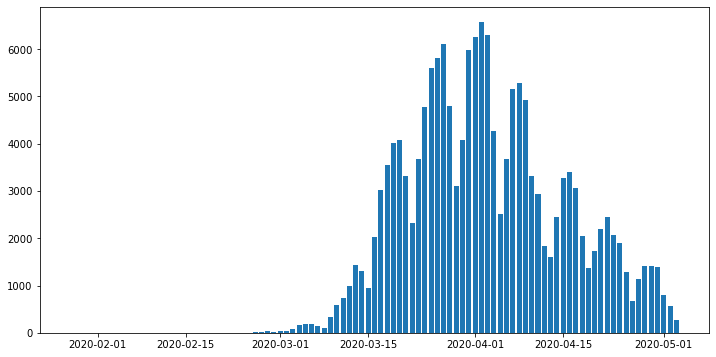

In [9]:
fig,ax = plt.subplots(figsize = (12,6))
daily_cases = df.groupby('Meldedatum').sum()['AnzahlFall']
plt.bar(daily_cases.index,np.array(daily_cases))
plt.show()

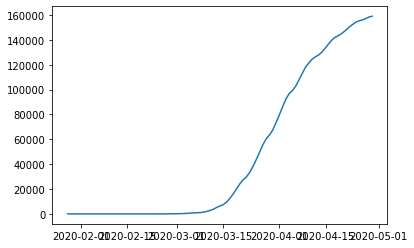

In [49]:
plt.plot(np.cumsum(df.groupby('Meldedatum').sum()['AnzahlFall']))

In [10]:
states = list(df.Bundesland.unique())
inhabitants = {'Nordrhein-Westfalen': 17933000,
               'Bayern': 13077000,
               'Baden-Württemberg': 11070000,
               'Niedersachsen': 7982000,
               'Hessen': 6266000,
               'Rheinland-Pfalz': 4085000,
               'Sachsen':4078000,
               'Berlin': 3645000,
               'Schleswig-Holstein': 2897000,
               'Brandenburg': 2512000,
               'Sachsen-Anhalt': 2208000,
               'Thüringen': 2143000,
               'Hamburg': 2143000,
               'Mecklenburg-Vorpommern': 1610000,
               'Saarland': 991000,
               'Bremen': 683000}

In [11]:
states_cases = df.groupby(['Bundesland','Meldedatum']).sum()['AnzahlFall']

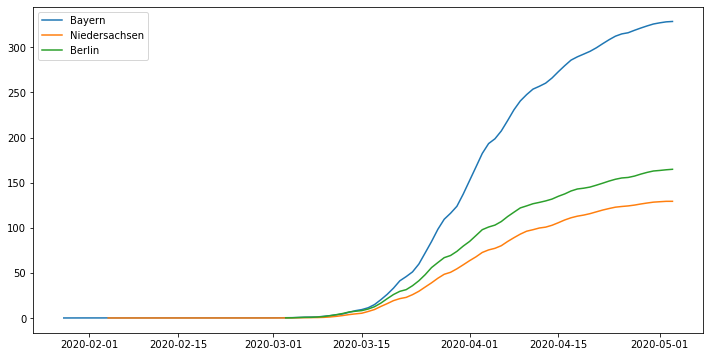

In [12]:
fig,ax = plt.subplots(figsize = (12,6))
states_to_plot = ['Bayern','Niedersachsen','Berlin']
for state in states_to_plot:
    ax.plot(np.cumsum(states_cases[state])/(inhabitants[state]/10**5))
ax.legend(states_to_plot)    
plt.show()

In [148]:
rki_landkreis = list(df['IdLandkreis'].unique())
rki_landkreis

[1001,
 1002,
 1003,
 1004,
 1051,
 1053,
 1054,
 1055,
 1056,
 1057,
 1058,
 1059,
 1060,
 1061,
 1062,
 2000,
 3101,
 3102,
 3103,
 3151,
 3153,
 3154,
 3155,
 3157,
 3158,
 3159,
 3241,
 3251,
 3252,
 3254,
 3255,
 3256,
 3257,
 3351,
 3352,
 3353,
 3354,
 3355,
 3356,
 3357,
 3358,
 3359,
 3360,
 3361,
 3401,
 3402,
 3403,
 3404,
 3405,
 3451,
 3452,
 3453,
 3454,
 3455,
 3456,
 3457,
 3458,
 3459,
 3460,
 3461,
 3462,
 4011,
 4012,
 5111,
 5112,
 5113,
 5114,
 5116,
 5117,
 5119,
 5120,
 5122,
 5124,
 5154,
 5158,
 5162,
 5166,
 5170,
 5314,
 5315,
 5316,
 5334,
 5358,
 5362,
 5366,
 5370,
 5374,
 5378,
 5382,
 5512,
 5513,
 5515,
 5554,
 5558,
 5562,
 5566,
 5570,
 5711,
 5754,
 5758,
 5762,
 5766,
 5770,
 5774,
 5911,
 5913,
 5914,
 5915,
 5916,
 5954,
 5958,
 5962,
 5966,
 5970,
 5974,
 5978,
 6411,
 6412,
 6413,
 6414,
 6431,
 6432,
 6433,
 6434,
 6435,
 6436,
 6437,
 6438,
 6439,
 6440,
 6531,
 6532,
 6533,
 6534,
 6535,
 6611,
 6631,
 6632,
 6633,
 6634,
 6635,
 6636,
 7111,

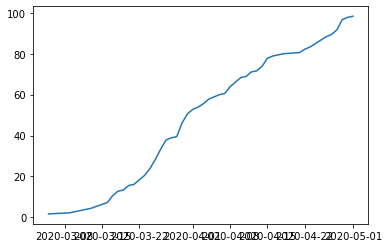

In [14]:
plt.plot(np.cumsum(df.groupby(['Landkreis','Meldedatum']).sum()['AnzahlFall']['LK Celle'])/1.8)

,IdLandkreis,Bezeichnung,Name,NUTS3,area,pop_tot,pop_male,pop_female,pop_per_sqkm2
1,1001,Kreisfreie Stadt,"Flensburg, Stadt",DEF01,56.73,89504.0,44599.0,44905.0,1578.0
2,1002,Kreisfreie Stadt,"Kiel, Landeshauptstadt",DEF02,118.65,247548.0,120566.0,126982.0,2086.0
3,1003,Kreisfreie Stadt,"Lübeck, Hansestadt",DEF03,214.19,217198.0,104371.0,112827.0,1014.0
4,1004,Kreisfreie Stadt,"Neumünster, Stadt",DEF04,71.66,79487.0,39241.0,40246.0,1109.0
5,1051,Kreis,Dithmarschen,DEF05,1428.17,133210.0,65720.0,67490.0,93.0
6,1053,Kreis,Herzogtum Lauenburg,DEF06,1263.07,197264.0,96881.0,100383.0,156.0
7,1054,Kreis,Nordfriesland,DEF07,2083.55,165507.0,81099.0,84408.0,79.0
8,1055,Kreis,Ostholstein,DEF08,1393.02,200581.0,96765.0,103816.0,144.0
9,1056,Kreis,Pinneberg,DEF09,664.25,314391.0,154211.0,160180.0,473.0
10,1057,Kreis,Plön,DEF0A,1083.56,128647.0,62532.0,66115.0,119.0


In [133]:
destatis_landkreis

[1001,
 1002,
 1003,
 1004,
 1051,
 1053,
 1054,
 1055,
 1056,
 1057,
 1058,
 1059,
 1060,
 1061,
 1062,
 2000,
 3101,
 3102,
 3103,
 3151,
 3153,
 3154,
 3155,
 3157,
 3158,
 3159,
 3241,
 3251,
 3252,
 3254,
 3255,
 3256,
 3257,
 3351,
 3352,
 3353,
 3354,
 3355,
 3356,
 3357,
 3358,
 3359,
 3360,
 3361,
 3401,
 3402,
 3403,
 3404,
 3405,
 3451,
 3452,
 3453,
 3454,
 3455,
 3456,
 3457,
 3458,
 3459,
 3460,
 3461,
 3462,
 4011,
 4012,
 5111,
 5112,
 5113,
 5114,
 5116,
 5117,
 5119,
 5120,
 5122,
 5124,
 5154,
 5158,
 5162,
 5166,
 5170,
 5314,
 5315,
 5316,
 5334,
 5358,
 5362,
 5366,
 5370,
 5374,
 5378,
 5382,
 5512,
 5513,
 5515,
 5554,
 5558,
 5562,
 5566,
 5570,
 5711,
 5754,
 5758,
 5762,
 5766,
 5770,
 5774,
 5911,
 5913,
 5914,
 5915,
 5916,
 5954,
 5958,
 5962,
 5966,
 5970,
 5974,
 5978,
 6411,
 6412,
 6413,
 6414,
 6431,
 6432,
 6433,
 6434,
 6435,
 6436,
 6437,
 6438,
 6439,
 6440,
 6531,
 6532,
 6533,
 6534,
 6535,
 6611,
 6631,
 6632,
 6633,
 6634,
 6635,
 6636,
 7111,

In [149]:
for kreis in rki_landkreis:
    if kreis in destatis_landkreis:
        continue
    else:
        print(kreis, df[df['IdLandkreis']==kreis]['Landkreis'].unique())

11012 ['SK Berlin Reinickendorf']


In [35]:
pd.read_excel??